In [ ]:
!pip install geopandas shapely pyproj folium contextily

In [13]:
!pip install h3

In [14]:
# Imports
# Geometry
from h3 import h3
from shapely.geometry import Point, Polygon, LineString
from geopy.distance import distance
from geopy.distance import geodesic
from shapely.wkt import loads


# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import ast
from pandas.io.json import json_normalize

# Network
import requests
import time

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Define the Overpass API endpoint
endpoint = "https://overpass-api.de/api/interpreter"
# Define the latitude and longitude of the centroid if La Bota
lat_toctiuco = -0.20985476660321467
lon_toctiuco = -78.52568864705847
lat_bota = -0.11562405304648693
lon_bota = -78.45956887257326

In [17]:
# Define the Overpass API query --around 1000 meters
query = '[out:json][timeout:25];(way["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|service|footway|pedestrian|track|cycleway|path"](around:1000,' + str(lat_toctiuco) + ',' + str(lon_toctiuco) + '););out geom;'

# Send the request to the Overpass API
response = requests.get(endpoint, params={'data': query})

# Convert the response to JSON format
data = response.json()['elements']

# Create a pandas DataFrame to store the data
df = pd.DataFrame(data)
# Extract values from the 'geometry' column and convert to LineString
geometry = [LineString([(d['lon'], d['lat']) for d in x]) for x in df['geometry']]
df['linestring'] = geometry

# Extract values from the 'tags' column and create new columns
df['alt_name'] = df['tags'].apply(lambda x: x['alt_name'] if 'alt_name' in x else None)
df['highway'] = df['tags'].apply(lambda x: x['highway'] if 'highway' in x else None)
df['name'] = df['tags'].apply(lambda x: x['name'] if 'name' in x else None)

# Drop the original 'tags' column
df.drop(columns=['tags', 'id', 'bounds', 'nodes', 'geometry'], inplace=True)

# Rename columns
df.rename(columns={'linestring': 'geometry'}, inplace=True)

#Make geodataframe
gdf_toctiuco = gpd.GeoDataFrame(df, geometry='geometry')

In [18]:
# Define the Overpass API query --around 1000 meters
query = '[out:json][timeout:25];(way["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|service|footway|pedestrian|track|cycleway|path"](around:1000,' + str(lat_bota) + ',' + str(lon_bota) + '););out geom;'

# Send the request to the Overpass API
response = requests.get(endpoint, params={'data': query})

# Convert the response to JSON format
data = response.json()['elements']

# Create a pandas DataFrame to store the data
df = pd.DataFrame(data)
# Extract values from the 'geometry' column and convert to LineString
geometry = [LineString([(d['lon'], d['lat']) for d in x]) for x in df['geometry']]
df['linestring'] = geometry

# Extract values from the 'tags' column and create new columns
df['alt_name'] = df['tags'].apply(lambda x: x['alt_name'] if 'alt_name' in x else None)
df['highway'] = df['tags'].apply(lambda x: x['highway'] if 'highway' in x else None)
df['name'] = df['tags'].apply(lambda x: x['name'] if 'name' in x else None)

# Drop the original 'tags' column
df.drop(columns=['tags', 'id', 'bounds', 'nodes', 'geometry'], inplace=True)

# Rename columns
df.rename(columns={'linestring': 'geometry'}, inplace=True)

#Make geodataframe
gdf_bota = gpd.GeoDataFrame(df, geometry='geometry')

In [23]:
# Shape files read and set projection
labota_shp = gpd.read_file("/content/drive/MyDrive/Diversa/LaBota.shp")
if labota_shp.crs is None:
    labota_shp.crs = 'epsg:32717'
labota_shp = labota_shp.to_crs('epsg:4326')

toctiuco_shp = gpd.read_file("/content/drive/MyDrive/Diversa/Toctiuco.shp")
if toctiuco_shp.crs is None:
    toctiuco_shp.crs = 'epsg:32717'
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')

In [24]:
# Extract the bounding box of the labota_shp
bbox_bota = labota_shp.total_bounds
polygon_bota = Polygon([(bbox_bota[0], bbox_bota[1]), (bbox_bota[0], bbox_bota[3]), (bbox_bota[2], bbox_bota[3]), (bbox_bota[2], bbox_bota[1])])
# Get the centroid of the bounding box
centroid_bota = polygon_bota.centroid
# Print the centroid coordinates
print(centroid_bota.x, centroid_bota.y)

-78.45956887257326 -0.11562405304648693


In [25]:
# Extract the bounding box of the labota_shp
bbox_toctiuco = toctiuco_shp.total_bounds
polygon_toctiuco = Polygon([(bbox_toctiuco[0], bbox_toctiuco[1]), (bbox_toctiuco[0], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[1])])
# Get the centroid of the bounding box
centroid_toctiuco = polygon_toctiuco.centroid
# Print the centroid coordinates
print(centroid_toctiuco.x, centroid_toctiuco.y)

-78.52568864705847 -0.20985476660321467


In [26]:
polygon1 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_bota[1], bbox_bota[0]],
[bbox_bota[1], bbox_bota[2]],
[bbox_bota[3], bbox_bota[2]],
[bbox_bota[3], bbox_bota[0]],
[bbox_bota[1], bbox_bota[0]]
]
]
}

resolution = 10
hexagons1 = h3.polyfill(polygon1, resolution, geo_json_conformant=False)
hexagons1_list = list(hexagons1)

polygon2 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_toctiuco[1], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[0]]
]
]
}

resolution = 10
hexagons2 = h3.polyfill(polygon2, resolution, geo_json_conformant=False)
hexagons2_list = list(hexagons2)



polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

all_polys1 = gpd.GeoSeries(list(map(polygonise, hexagons1)), \
                                      index=hexagons1, \
                                      crs="EPSG:4326" \
                                     )

all_polys2 = gpd.GeoSeries(list(map(polygonise, hexagons2)), \
                                      index=hexagons2, \
                                      crs="EPSG:4326" \
                                     )

In [27]:
# Spatial join the H3 layers and the shapefiles
all_polys1_gdf = all_polys1.to_frame()
LaBota_H3 = gpd.sjoin( all_polys1_gdf, labota_shp, predicate='intersects').reset_index()
LaBota_H3 = LaBota_H3.drop_duplicates(subset='index')
all_polys2_gdf = all_polys2.to_frame()
Toctiuco_H3 = gpd.sjoin( all_polys2_gdf, toctiuco_shp, predicate='intersects').reset_index()
Toctiuco_H3 = Toctiuco_H3.drop_duplicates(subset='index')

In [19]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# Radius
radius = 1500  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_bota, lon_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_toctiuco, lon_toctiuco, radius)

In [20]:
# Define a function that maps 'highway' types to colors
def get_color(road_type):
    if road_type in ['footway', 'path', 'tertiary', 'pedestrian']:
        return '#04E762'
    else:
        return '#FC17E5'  # default color for other road types

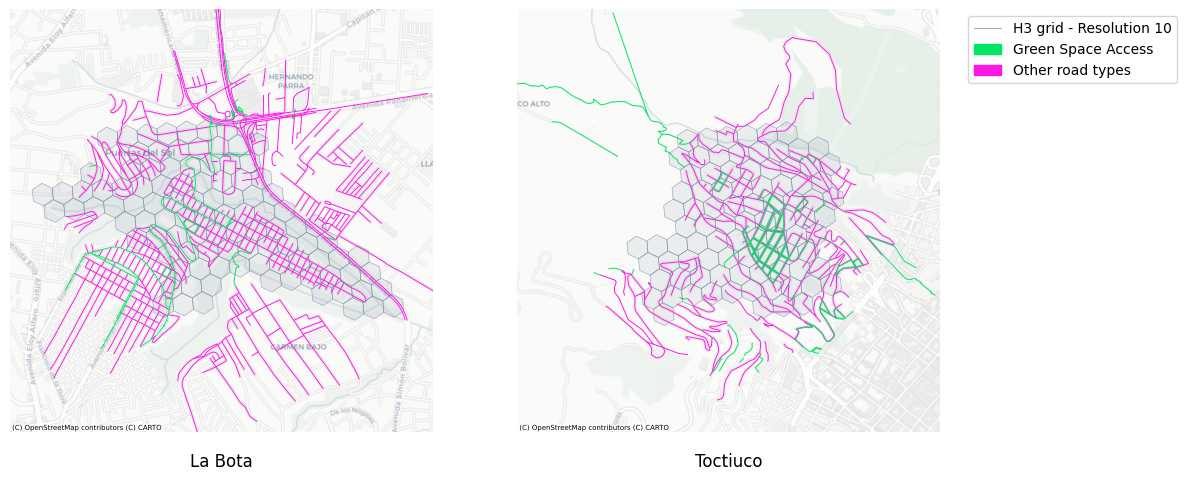

In [30]:
# Convert geodataframe to Web Mercator (epsg:3857)
LaBota_H3.crs = "EPSG:4326"
LaBota_H32 = LaBota_H3.to_crs(epsg=3857)
Toctiuco_H3.crs = "EPSG:4326"
Toctiuco_H32 = Toctiuco_H3.to_crs(epsg=3857)

# Convert geodataframe to Web Mercator (epsg:3857)
gdf_bota.crs = "EPSG:4326"
gdf_bota2 = gdf_bota.to_crs(epsg=3857)
gdf_bota2['color'] = gdf_bota2['highway'].apply(get_color)
gdf_toctiuco.crs = "EPSG:4326"
gdf_toctiuco2 = gdf_toctiuco.to_crs(epsg=3857)
gdf_toctiuco2['color'] = gdf_toctiuco2['highway'].apply(get_color)

# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
gdf_bota2.plot(ax=ax, color=gdf_bota2['color'], linewidth=0.7)
LaBota_H32.boundary.plot(ax=ax, color='#7889A1', linewidth=0.4, alpha=0.8)
LaBota_H32.plot(ax=ax, color='#7889A1', linewidth=0.1, alpha=0.12)
# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
gdf_toctiuco2.plot(ax=ax, color=gdf_toctiuco2['color'], linewidth=0.7)
Toctiuco_H32.boundary.plot(ax=ax, color='#7889A1', linewidth=0.4, alpha=0.8)
Toctiuco_H32.plot(ax=ax, color='#7889A1', linewidth=0.1, alpha=0.12)
# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Define your color legend patches
color_patches = [Patch(facecolor='#04E762', edgecolor='#04E762',
                         label='Green Space Access'),
                   Patch(facecolor='#FC17E5', edgecolor='#FC17E5',
                         label='Other road types')]
# Your H3 grid Line2D
grid_line = [Line2D([0], [0], color='#7889A1', lw=0.5, label='H3 grid - Resolution 10')]

# Merge all elements
legend_elements = grid_line + color_patches

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

In [31]:
# Save the figure in 300 dpi with tiff format
fig.savefig('/content/drive/MyDrive/Diversa/figures/H3_ROADS.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('/content/drive/MyDrive/Diversa/figures/H3_ROADS.jpg', dpi=300, format='jpeg', bbox_inches='tight')